## Goals

This is an example of the current capacities of echopype processing for the EK60 echosounder. Inspired by
https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/ms_PacificHake_EK60_cruisetracks.ipynb

## Description


In [1]:
import fsspec
import numpy as np
import geopandas as gpd
import xarray as xr
import echopype as ep
import echopype.visualize as epviz
import matplotlib.pyplot as plt
from echopype.qc import exist_reversed_time
from pathlib import Path
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Data import

#### Establish AWS S3 file system connection and generate list of target EK60 .raw files

Access and inspect the publicly accessible NCEI WCSD S3 bucket on the AWS cloud as if it were a local file system. This will be done through the Python fsspec file system and bytes storage interface. We will use fsspec.filesystem.glob (fs.glob) to generate a list of all EK60 .raw data files in the bucket, then filter on file names for target dates of interest.

The directory path on the ncei-wcsd-archive S3 bucket is s3://ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/. All .raw files from the 2017 Hake survey cruise are found here.

We will read data from 2017-07-28

In [2]:
fs = fsspec.filesystem('s3', anon=True)

bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")

# print out the last two S3 raw file paths in the list
s3rawfiles[-2:]

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170913-T180733.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Winter2017-D20170615-T002629.raw']

In [3]:
raw_files = [
    s3path for s3path in s3rawfiles 
    if any([f"D2017{datestr}" in s3path for datestr in ['0728']]) 
]

raw_files = [
    s3path for s3path in raw_files
    if any([f"EK60" in s3path])
]

In [4]:
print(f"There are {len(raw_files)} target raw files available")
raw_files[-1:]

There are 97 target raw files available


['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T235144.raw']

#### Metadata creation

In [5]:
def populate_metadata(ed, raw_fname):
    """
    Manually populate into the "ed" EchoData object 
    additional metadata about the dataset and the platform
    """
    
    # -- SONAR-netCDF4 Top-level Group attributes
    survey_name = (
        "2017 Joint U.S.-Canada Integrated Ecosystem and "
        "Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')"
    )
    ed['Top-level'].attrs['title'] = f"{survey_name}, file {raw_fname}"
    ed['Top-level'].attrs['summary'] = (
        f"EK60 raw file {raw_fname} from the {survey_name}, converted to a SONAR-netCDF4 file using echopype."
        "Information about the survey program is available at "
        "https://www.fisheries.noaa.gov/west-coast/science-data/"
        "joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey"
    )

    # -- SONAR-netCDF4 Platform Group attributes
    # Per SONAR-netCDF4, for platform_type see https://vocab.ices.dk/?ref=311
    ed['Platform'].attrs['platform_type'] = "Research vessel"
    ed['Platform'].attrs['platform_name'] = "Bell M. Shimada"  # A NOAA ship
    ed['Platform'].attrs['platform_code_ICES'] = "315"

In [6]:
base_dpath = Path('./exports/basic_echopype_processing_ek60_multiple')
base_dpath.mkdir(exist_ok=True, parents=True)

converted_dpath = Path(base_dpath / 'hakesurvey_convertedzarr')
converted_dpath.mkdir(exist_ok=True)
calibrated_dpath = (base_dpath / 'hakesurvey_calibratednc')
calibrated_dpath.mkdir(exist_ok=True)
bucketed_dpath = (base_dpath / 'hakesurvey_bucketednc')
bucketed_dpath.mkdir(exist_ok=True)

## Multiple file processing

In [7]:
raw_fpath = Path(raw_files[1])

ed = ep.open_raw(
            f"s3://{raw_fpath}",
            sonar_model='EK60',
            storage_options={'anon': True}
        )

# Manually populate additional metadata about the dataset and the platform
populate_metadata(ed, raw_fpath.name)

# Save to converted Zarr format
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

In [8]:
%%time

for s3rawfpath in raw_files:
    raw_fpath = Path(s3rawfpath)
    try:
        # Access file directly from S3 to create a converted EchoData object in memory
        ed = ep.open_raw(
            f"s3://{raw_fpath}",
            sonar_model='EK60',
            storage_options={'anon': True}
        )
        # Manually populate additional metadata about the dataset and the platform
        populate_metadata(ed, raw_fpath.name)

        # Save to converted Zarr format
        ed.to_zarr(save_path=converted_dpath, overwrite=True)

        # Use the EchoData object "ed" to generate calibrated and
        # computed MVBS files that will be saved to netcdf
        ds_Sv = ep.calibrate.compute_Sv(ed)
        ds_Sv_clean = ep.preprocess.remove_noise(    # obtain a denoised Sv dataset
           ds_Sv,             # calibrated Sv dataset
           range_sample_num=30,  # number of samples along the range_sample dimension for estimating noise
           ping_num=5,        # number of pings for estimating noise
        )
        ds_Sv.to_netcdf(calibrated_dpath/f"clean_{raw_fpath.stem}.nc")
        ds_MVBS = ep.preprocess.compute_MVBS(
            ds_Sv_clean,
            range_meter_bin=5,  # in meters
            ping_time_bin='20s'  # in seconds
        )
        ds_MVBS.to_netcdf(bucketed_dpath / f"MVBS_{raw_fpath.stem}.nc")
    except Exception as e:
        print(f"Failed to process raw file {raw_fpath.name}: {e}")

print("Finished processing")

Finished processing
CPU times: user 7min 9s, sys: 1min 34s, total: 8min 44s
Wall time: 30min 14s


In [9]:
for datapath in converted_dpath.glob('*'):
    ed = ep.open_converted(datapath)
    # Test for a negative ping_time increment in sequential timestamps, in the Sonar/Beam_group1 group
    if exist_reversed_time(ds=ed['Sonar/Beam_group1'], time_name="ping_time"):
        print(f"Reversed time in {datapath}")

#### Read MVBS data and concatenate in a single dataset

In [10]:
%%time
MVBS_ds = xr.open_mfdataset(
    str(bucketed_dpath / 'MVBS_*.nc'), 
    combine='by_coords'
)

CPU times: user 1.24 s, sys: 123 ms, total: 1.36 s
Wall time: 1.54 s


In [11]:
MVBS_ds

<xarray.Dataset>
Dimensions:            (channel: 3, ping_time: 4421, echo_range: 150)
Coordinates:
  * ping_time          (ping_time) datetime64[ns] 2017-07-28T00:05:20 ... 201...
  * channel            (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES18-11...
  * echo_range         (echo_range) float64 0.0 5.0 10.0 ... 735.0 740.0 745.0
Data variables:
    Sv                 (channel, ping_time, echo_range) float64 dask.array<chunksize=(3, 60, 150), meta=np.ndarray>
    frequency_nominal  (ping_time, channel) float64 dask.array<chunksize=(60, 3), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2023-06-30T09:43:52Z
    processing_function:          commongrid.compute_MVBS

#### Visualising our initial data

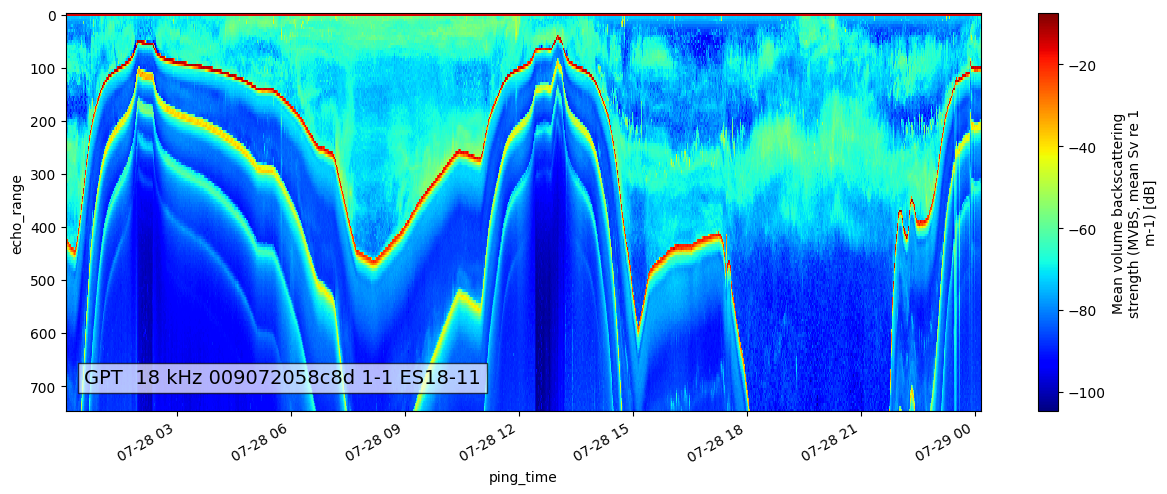

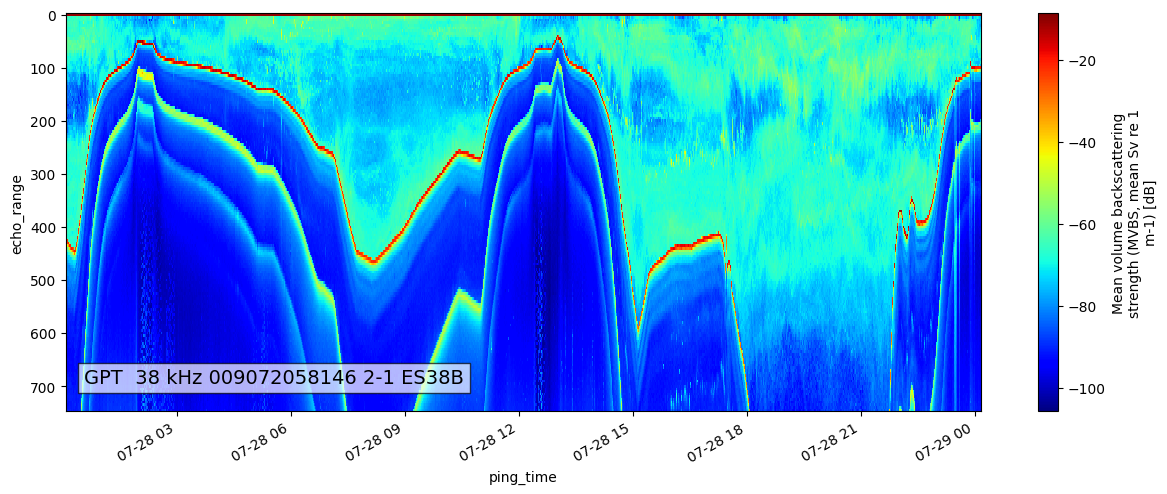

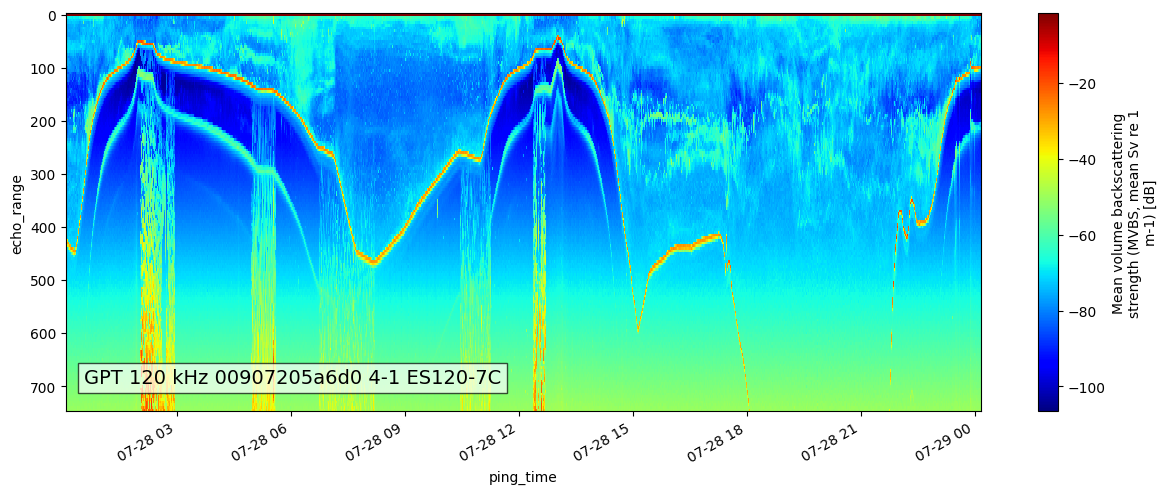

In [12]:
#Let's visualise this
epviz.create_echogram(MVBS_ds)